In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm.autonotebook import tqdm 

from src import read_dicom, Detector, Siddon

In [2]:
volume, spacing = read_dicom("../data/cxr/")
volume = torch.tensor(volume)
siddon = Siddon(spacing=spacing, center=[0.0, 0.0, 0.0], volume=volume)

In [3]:
source = [-10., -10., -15.]
target = [400., 375., 350.]

detector = Detector(
    source=source,
    center=target,
    height=25,
    width=25,
    delx=1.,
    dely=1.,
)

rays = detector.make_xrays()

In [4]:
drr = [siddon.raytrace(source, target) for source, target in tqdm(rays)]
drr = torch.tensor(drr)
drr = drr.reshape(25, 25)

  0%|          | 0/625 [00:00<?, ?it/s]

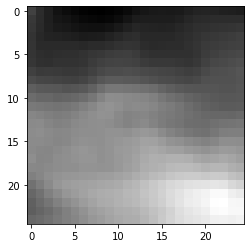

In [6]:
plt.imshow(drr, cmap="gray")
plt.show()